## Content

1. Loading and Visualizing data
2. Feature mapping
3. Regularization
4. Using model from library
5. Plotting the result
6. Accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

## 1. Loading and Visualizing data

In [2]:
# The data is from Coursera Machine Learning course/week3/ex2data2.txt
data = np.loadtxt('../data/data4.txt', delimiter = ',')

# Some useful variables
m = data.shape[0]      # Number of training examples
n = data.shape[1] - 1  # Number of features

X = data[:, 0:n]  # Score of 2 different tests on a microchip
Y = data[:, n, np.newaxis]  # Pass or Fail

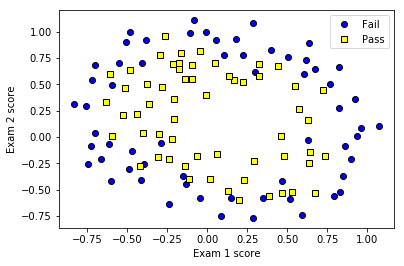

In [3]:
figureId = 1

def plotData(X, Y):
    global figureId
    plt.figure(figureId)
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    neg = np.where(Y == 0)[0]  # index of fail examples
    pos = np.where(Y == 1)[0]  # index of pass examples
    plt.plot(X[neg, 0], X[neg, 1], 'o', color = 'blue', mec = 'black', label = 'Fail')
    plt.plot(X[pos, 0], X[pos, 1], 's', color = 'yellow', mec = 'black', label = 'Pass')
    plt.legend(loc = 'upper right')
    plt.draw()
    
    figureId += 1
    
plotData(X, Y)
plt.show()

## 2. Feature mapping

The data now is no longer (or atleast almost) linearly separable, it means we need to find a more complex decision boundary to classify the data better.

Excluding bias term, we currently only have 2 original features that is $x_{1}$ - the score of the 1st test and $x_{2}$ - the score of the 2nd test. We can deduct new features from those 2 such as $x_1x_2$, $x_1^{2}x_2$, $x_1x_2^{2}$ etc.

In implementation: if we're given a integer n, we can obtain new features from $x_1$, $x_2$ by taking the factors in the binomial expansion of the polynomial $(x_1 + x_2)^{1..n}$ (and omitting the coefficients). For example with n = 3:

$$(x_1 + x_2)^1 = x_1 + x_2$$
$$(x_1 + x_2)^2 = x_1^2 + 2x_1x_2 + x_2^2$$
$$(x_1 + x_2)^3 = x_1^3 + 3x_1^2x_2 + 3x_1x_2^2 + x_2^3$$

our features are: $(x_1, x_2, x_1^2, x_1x_2, x_2^{2}, x_1^{3}, x_1^2x_2, x_1x_2^2, x_2^{3})$ - excluding bias term.

In [4]:
def map_feature(X1, X2, degree):
    X1 = np.atleast_1d(X1)  # In case X1 has 0 rank
    X2 = np.atleast_1d(X2)
    X = np.ones((X1.shape[0], 1))  # Adding bias term
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            new_feature = (X1**(i - j)) * (X2**j)
            X = np.column_stack((X, new_feature))
    return X
    
degree = 6  # Highest degree of polynomial feature 
            # in order to fit the data better
X = map_feature(X[:, 0, np.newaxis], X[:, 1, np.newaxis], degree)

## 3. Regularization

Adding more features can help your decision boundary becomes complex and classify the _training data_ accurately. However it may be depended too much on the training data and does not perform well on the new data (we call it the generalization on the new data).

So we have 2 (contracy) problems here:
* The algorithm fits the training data very well. We call this **overfitting**, or **high variance**. The algorithm may have a high probability of lossing the generalization on new data.
* The algorithm maps the training data poorly. We call this **underfitting**, or **high bias**.

What we want to achieve is something in between (also the algorithm needs to perform well on new data), and regularization comes into place to help us make a trade-off between these two. 

If we want to use regularization in our (logistic) model: a regularization term is added to the cost function:

$$ J(\theta) = \frac{1}{m}\sum_{i = 1}^{m}-y^{(i)}log(h_{\theta}(x^{(i)}) -(1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}) ~(1) + \frac{\lambda}{m}\sum_{j = 1}^{n}\theta_{j}^{2} ~ (2)$$

_$\lambda$ is regularization parameter (and just like the learning rate $\alpha$, $\lambda$ also needs to be tuned)._

Notice that $\theta_{0}$ doesn't appear in the regularization term because it make very little difference to the results in pratice.

Now, the cost function has 2 goals:
+ First goal: minimizing the term $(1)$, in order to fit the training data well (ie. minimizing the error).
+ Second goal: keep $\theta$ in the term small $(2)$, the decision boundary becomes smoother and it may predict the new data well.

And $\lambda$ controls the trade off between these 2 different goals:
+ If $\lambda$ is small: the term $(2)$ is also small, the algorithm will now focus more on minimizing the term $(1)$.
+ If $\lambda$ is large: in order to minimize the cost function, $\theta$ is penalized heavily ($\theta \approx 0$, $h_{\theta}(x) \approx \theta_{0}$, so decision boundary doesn't fit the data well).

Taking the derivative of cost function:

$$ \frac{dJ}{\theta_{0}} = \frac{1}{m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)} - y^{(i)})x_{0}^{(i)}$$

$$ \frac{dJ}{\theta_{j \neq 0}} = \frac{1}{m}\left [\sum_{i = 1}^{m}(h_{\theta}(x^{(i)} - y^{(i)})x_{j}^{(i)} + \lambda \theta_{j} \right ] $$

Having the derivative, you can code the gradient descent yourself. In the next section I will use `linear_model` from `sklearn` library.

## 4. Using model from library

In [5]:
# C is the inverse of lambda: the higher C is, the more
# the algorithm will focus on fitting the data well
logreg = linear_model.LogisticRegression(C = 1)

# Create an instance of Neighbors Classifier and fit the data
logreg.fit(X, Y.ravel())

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 5. Plotting the result

Traditionally, from $h_{\theta}(x) = 0$, we want to deduct $x_1 = f(x_2)$ or $x_2 = f(x_1)$ in order to draw the decision boundary. Since $h_{\theta}(x)$ is now too complex, we will use another way for plotting. 

The idea is very simple: for each $x = (x_1, x_2)$ point in the plane; we assign it a color if $h_{\theta}(x) \lt 0$, or another color if $h{\theta}(x) \ge 0$. The boundary decision is the border between these 2 different-color regions.

In [6]:
# Plot the decision boundary. For that, we will assign a color 
# to each point in the mesh [x_min, x_max] x [y_min, y_max]
h = 0.02  # Step size in the mesh
x_min, x_max = X[:, 1].min() - .5, X[:, 1].max() + .5  # X1 min and max
y_min, y_max = X[:, 2].min() - .5, X[:, 2].max() + .5  # X2 min and max
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(map_feature(xx.ravel(), yy.ravel(), degree))  # Predict the label of the mesh

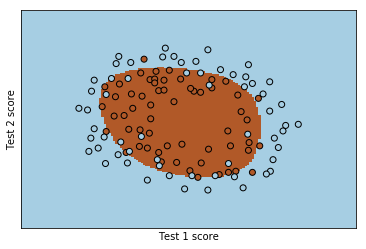

In [7]:
Z = Z.reshape(xx.shape)
plt.figure(figureId)
plt.pcolormesh(xx, yy, Z, cmap = plt.cm.Paired)  # cmap: a color map
                                                 # Paired means it only has 2 colors (0, 1)
    
# Also plot the training examples
# Each point is assigned a value in c array, this value is used
# to color the point by mapping to cmap.
plt.scatter(X[:, 1], X[:, 2], c = Y, edgecolors = 'k', cmap = plt.cm.Paired)

plt.xlabel('Test 1 score')
plt.ylabel('Test 2 score')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

## 6. Accuracy

In [14]:
Y_pred = logreg.predict(X)
Y_pred = Y_pred.reshape(Y.shape)
accuracy = np.sum((Y == Y_pred)) * 100 / m
print('Accuracy = %f' % accuracy)

Accuracy = 83.050847
